In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data is the compressor data read in as a pandas dataframe 
data = pd.read_csv('C:/Users/bhedayat/Documents/Mtell/Comrpessor1_Export_RevA.csv')
data_m = data.as_matrix()

C:\Users\bhedayat\Anaconda3\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Labeling data
I labled the anamoly data based on the fact that there is failure events on 9/17/2013.
There are 96 failure events

In [2]:
fail = '9/17/2013' 
label_train = np.zeros((data.shape[0]))

for i in range(len(data_m[:,0])): 
    if fail in data_m[:,0][i]: 
        label_train[i] = 0 #failure
    else:
        label_train[i] = 1  #non-failure

In [3]:
comp_data = data_m[:,2:63] #Grabbing compressor feature data

### Visualizing data

Doing PCA on the data to visualize it in two dimensions I see three clearly defined clusters unfortunantly I also see the failure data mixed in with the good data and they don't have a clearly defined cluster.  
Also the two dimensions account for 98.7% of the variance in the data so I will be working with two dimensions.


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(comp_data)
comp_pca = pca.transform(comp_data)
print pca.explained_variance_ratio_

[ 0.98692038  0.00895006]


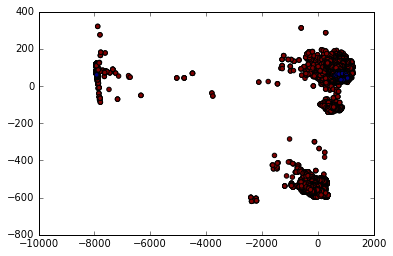

In [5]:
%matplotlib inline  
idx = np.where(label_train==0)[0]
failure = comp_pca[idx]

plt.scatter(comp_pca[:,0],comp_pca[:,1],c=label_train)
plt.scatter(failure[:,0],failure[:,1],c=label_train[idx])

### Kmeans
I did kmeans on the three visually defined clusters, even though the failure data is mixed in with good data doing unsupervised learning split the failure data among two clusters.
Doing kmeans for two clusters also splits failure data into two clusters

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(comp_pca)
train_label = kmeans.labels_


In [7]:
#Shows that failure data is split into two clusters
idx = np.where(label_train==0)[0]
train_label[idx]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

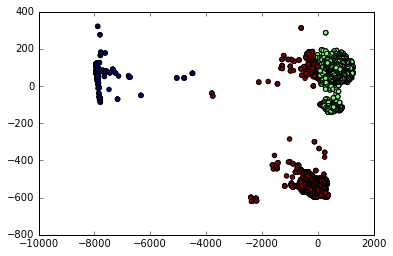

In [8]:
%matplotlib inline  
plt.scatter(comp_pca[:,0],comp_pca[:,1],c=train_label)

In [18]:
#Shows that failure is split into two clusters
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(comp_pca)
train_label_2 = kmeans2.labels_
idx = np.where(label_train==0)[0]
train_label_2[idx]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

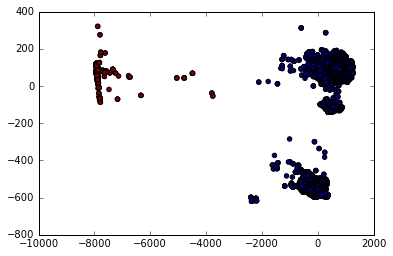

In [19]:
%matplotlib inline  
plt.scatter(comp_pca[:,0],comp_pca[:,1],c=train_label_2)

Since the failures are hard to distiguish with unsupervised learning, switch to supervised learning. If continuing with k-means I would have looked at the sillhouete values and see how similar points are to their cluster, but there computational power is too much for my computer causing it to crash and taking a subsample would be a biased decision

### Shuffling data

For supervised learning, I choose 70% of good data and falure data to train on the remaining to test.

In [10]:
idx = np.where(label_train==0)[0]
idx1 = np.where(label_train==1)[0]
anamoly_data = np.column_stack((comp_pca[idx],label_train[idx]))
good_data = np.column_stack((comp_pca[idx1], label_train[idx1]))
np.random.shuffle(anamoly_data)
np.random.shuffle(good_data)
y_train = np.concatenate((good_data[1:67086,2],anamoly_data[1:70,2]))
y_test = np.concatenate((good_data[67086:good_data.shape[0],2],anamoly_data[70:anamoly_data.shape[0],2]))
X_train = np.concatenate((good_data[1:67086,:2],anamoly_data[1:70,:2]))
X_test = np.concatenate((good_data[67086:good_data.shape[0],:2],anamoly_data[70:anamoly_data.shape[0],:2]))
print y_train.shape
print y_test.shape
print X_train.shape
print X_test.shape


(67154L,)
(28777L,)
(67154L, 2L)
(28777L, 2L)


### Nearest Neighbors 
For detection of failure data, I split it into two classes good data and failure data and did nearest neighbours  
The testing accuracy was 99.8% 

In [11]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [12]:
y_pred = clf.predict(X_test)
acc = y_pred == y_test
acc = acc.astype(int)
np.mean(acc)

0.99798450151162388